### Load and Prepare the Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the random seed for CPU
torch.manual_seed(42)

# Load dataset
df_train_val = pd.read_csv('Csv/second.csv')
# Drop the first column by index
df_train_val.drop(df_train_val.columns[0], axis=1, inplace=True)
df_test = pd.read_csv('Csv/second_test.csv')
# Drop the first column by index
df_test.drop(df_test.columns[0], axis=1, inplace=True)

# Split features and target
X_train_val = df_train_val.iloc[:, :-1].values
y_train_val = df_train_val.iloc[:, -1].values
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [2]:
df_train_val.shape

(37816, 109)

### Define the TabNet Model

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class TabNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TabNet, self).__init__()
        self.bn0 = nn.BatchNorm1d(num_features=input_dim)
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(num_features=64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.bn0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return x

# Initialize the TabNet model
input_dim = 108  # Number of features
output_dim = len(np.unique(y_train))  # Number of unique classes
model = TabNet(input_dim=input_dim, output_dim=output_dim)

### Train the Model

In [4]:
from torch.optim import Adam

# Assuming model, train_loader, and val_loader are defined elsewhere
optimizer = Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=False)  # Changed to keepdim=False for easier concatenation
            correct += pred.eq(target).sum().item()
            
            # Append current batch predictions and targets
            all_preds.append(pred)
            all_targets.append(target)
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / len(val_loader.dataset)
    return avg_loss, accuracy, all_preds, all_targets

# Initialize lists to track metrics
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

# Training and validation loop
epochs = 600
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_targets, val_preds = evaluate(model, val_loader, criterion)
    
    # Append current epoch metrics to lists
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_accuracy_list.append(train_accuracy)
    val_accuracy_list.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1, Train Loss: 1.5701, Train Accuracy: 41.18%, Val Loss: 1.4570, Val Accuracy: 45.08%
Epoch 2, Train Loss: 1.4014, Train Accuracy: 47.35%, Val Loss: 1.3618, Val Accuracy: 48.77%
Epoch 3, Train Loss: 1.3429, Train Accuracy: 49.23%, Val Loss: 1.3342, Val Accuracy: 49.26%
Epoch 4, Train Loss: 1.3133, Train Accuracy: 50.18%, Val Loss: 1.2949, Val Accuracy: 50.24%
Epoch 5, Train Loss: 1.2904, Train Accuracy: 51.13%, Val Loss: 1.3027, Val Accuracy: 49.41%
Epoch 6, Train Loss: 1.2736, Train Accuracy: 51.74%, Val Loss: 1.2538, Val Accuracy: 51.47%
Epoch 7, Train Loss: 1.2585, Train Accuracy: 52.30%, Val Loss: 1.2538, Val Accuracy: 51.61%
Epoch 8, Train Loss: 1.2482, Train Accuracy: 52.64%, Val Loss: 1.2439, Val Accuracy: 51.81%
Epoch 9, Train Loss: 1.2384, Train Accuracy: 52.85%, Val Loss: 1.2383, Val Accuracy: 51.88%
Epoch 10, Train Loss: 1.2318, Train Accuracy: 53.20%, Val Loss: 1.2374, Val Accuracy: 52.70%
Epoch 11, Train Loss: 1.2232, Train Accuracy: 53.69%, Val Loss: 1.2193, Val Acc

### Evaluate the Model

In [5]:
test_loss, test_accuracy, test_targets, test_preds = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.9743, Test Accuracy: 62.94%


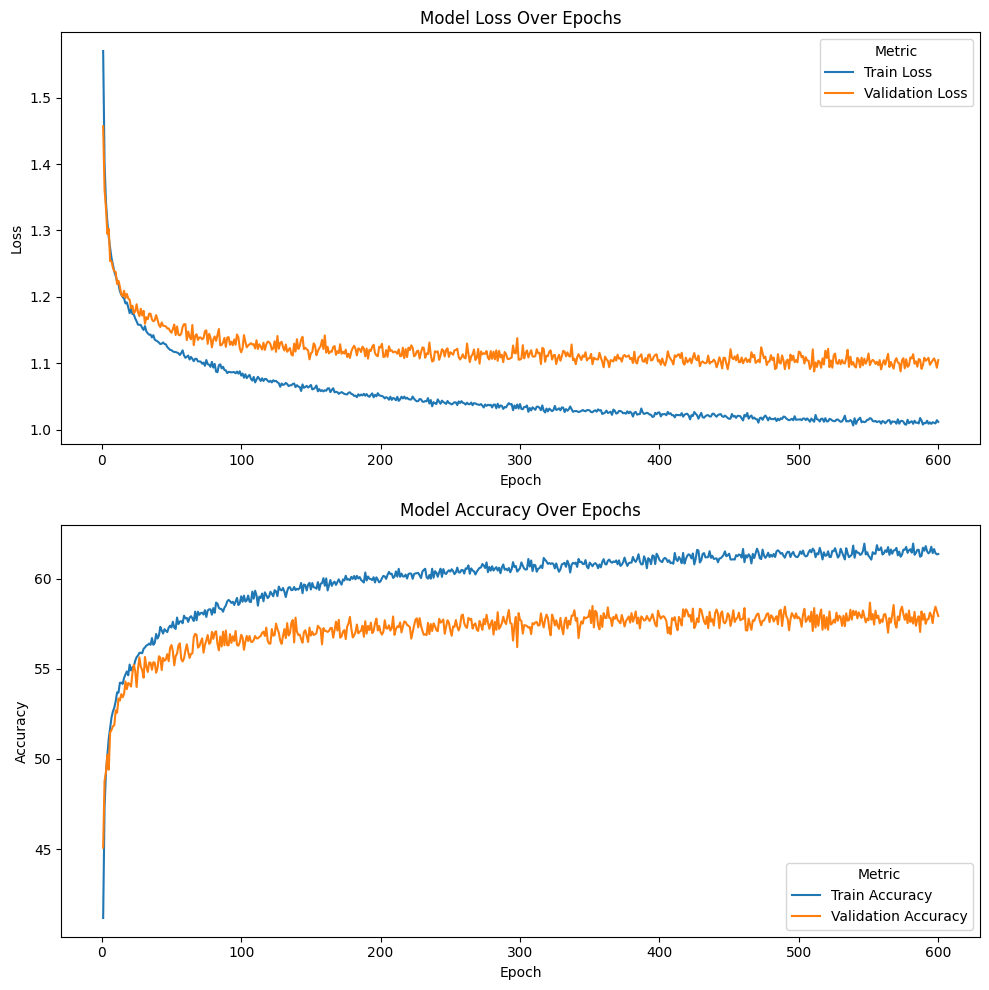

In [6]:
# Convert lists to a pandas DataFrame for easier plotting
data = {
    'Epoch': range(1, epochs + 1),
    'Train Loss': train_loss_list,
    'Validation Loss': val_loss_list,
    'Train Accuracy': train_accuracy_list,
    'Validation Accuracy': val_accuracy_list
}
df = pd.DataFrame(data)

# Melting the DataFrame to plot using seaborn
df_melted = pd.melt(df, id_vars=['Epoch'], value_vars=['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'],
                    var_name='Metric', value_name='Value')

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot for Loss
sns.lineplot(data=df_melted[df_melted['Metric'].isin(['Train Loss', 'Validation Loss'])], x='Epoch', y='Value', hue='Metric', ax=axs[0])
axs[0].set_title('Model Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

# Plot for Accuracy
sns.lineplot(data=df_melted[df_melted['Metric'].isin(['Train Accuracy', 'Validation Accuracy'])], x='Epoch', y='Value', hue='Metric', ax=axs[1])
axs[1].set_title('Model Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

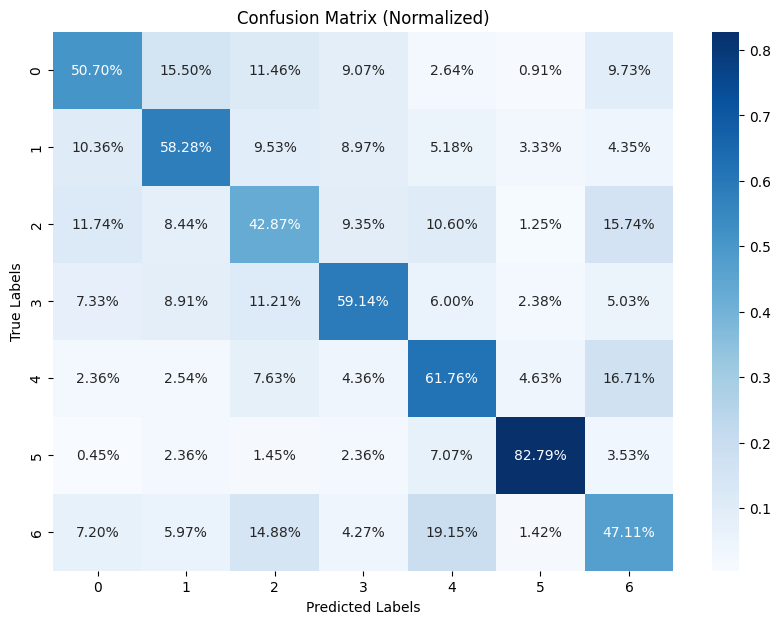

In [7]:
class_names = [0, 1, 2, 3, 4, 5, 6]

# Compute confusion matrix
cm = confusion_matrix(val_targets, val_preds)

# Normalize the confusion matrix to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()